# Calculating the delta of a digital option

Consider a **digital option** which pays 1 euro if the stock price at expiry is higher than thestrike and otherwise nothing. 

Since the payoff is not continues we have two options to calculate delta:

- Use the **Likelihood Ratio Method**
- Use the **Pathwise Method** after transforming the payoffs to ensure continuity (Using the CDF of a nromla distribution as a smoothing function)

## Likelihood ratio method

$$ \delta = e^{-rT} 1_{S_{t} > K} \frac{Z}{S_{o}\sigma \sqrt{T}} $$


In [275]:
import numpy as np
from numba import njit
from numba import jit
import matplotlib.pyplot as plt
from tqdm import tqdm

In [276]:
all_errors = [0.1, 0.01, 0.001, 0.0001, 0.00001]
all_iterations = [100, 1000, 10000, 100000]

In [277]:
# Parameters
T = 1
K = 99
S0 = 100
r = 0.06
sigma = 0.2

In [278]:
def digital_option(S0, K ,r ,sigma ,T ,n_iter):
    mc_payoffs = []
    for i in range(n_iter):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = S0 * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        # Check if digital option pays off
        if ST-K > 0:
            mc_payoffs.append( 1 * np.exp(-r)) # Present value of 1 euro
        else:
            mc_payoffs.append(0) # or present value of nothing

    # Returns a series of simulated prsent value digital option payoffs
    return mc_payoffs

In [279]:
import math
@njit
def get_analytical_delta(ST):
    d2 = (np.log(ST/K)+(r-(sigma**2)/2))/sigma * np.sqrt(T)
    def normal_cdf(x):
        q = math.erf(x / math.sqrt(2.0))
        return (1.0 + q) / 2.0

    analytical_delta = (np.exp(-r * T) * normal_cdf(d2))/(sigma * ST * np.sqrt(1))
    return analytical_delta

In [280]:
from scipy.stats import norm
@njit
def digital_delta_likelihood(S0, K ,r ,sigma ,T ,n_iter):
    sample_deltas = []
    sample_errors = []
    for i in range(n_iter):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = S0 * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        if ST > K: # Option has a value of 1
            delta = np.exp( -r * T) * 1 * ( phi / (S0*sigma*np.sqrt(T)))
            analytical_delta = get_analytical_delta(ST)
            
            sample_deltas.append(delta)
            sample_errors.append(abs(delta-analytical_delta))
        else: # Option has a value of 0
            delta = np.exp( -r * T) * 0 * ( phi / (S0*sigma*np.sqrt(T)))
            analytical_delta = get_analytical_delta(ST)

            sample_deltas.append(delta)
            sample_errors.append(abs(delta-analytical_delta))
    return sample_deltas, sample_errors

In [281]:
experiments = {}
for iteration in tqdm(all_iterations): # Different sample sizes
    mean_deltas = []
    mean_errors = []
    for i in range(iteration):
        deltas, errors = digital_delta_likelihood(S0, K ,r ,sigma ,T ,n_iter=10000)
        mean_deltas.append(np.mean(deltas))
        mean_errors.append(np.mean(errors))
    experiments[str(iteration)] = [mean_deltas,mean_errors]











  0%|          | 0/4 [00:00<?, ?it/s]









 25%|██▌       | 1/4 [00:01<00:05,  1.80s/it]









 50%|█████     | 2/4 [00:07<00:05,  2.94s/it]









 75%|███████▌  | 3/4 [00:54<00:16, 16.28s/it]









100%|██████████| 4/4 [11:23<00:00, 170.98s/it]


In [283]:
import pickle
with open('experiments_likelihood.pickle', 'wb') as handle:
    pickle.dump(experiments, handle, protocol=pickle.HIGHEST_PROTOCOL)

100 0.0002824061513247332
1000 0.00029226859839341635
10000 0.00027653612810650053
100000 0.00027982274736200463


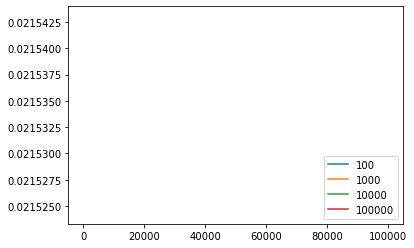

In [293]:
for ite in experiments.keys():
    # plt.plot(int(ite),np.mean(experiments[ite][1]),label=str(ite))
    print(ite, np.std(experiments[ite][0]))
plt.legend()

In [285]:
import random
def genhex():
    color = "#" + "%06x" % random.randint(0, 0xFFFFFF)
    return color

In [286]:

ST = 100
d2 = (np.log(ST/K)+(r-(sigma**2)/2))/sigma * np.sqrt(T)
delt = (np.exp(-r * T) * norm.cdf(d2))/(sigma * ST * np.sqrt(1))
delt

0.028196601488100263

In [287]:
print(np.random.normal(d2,sigma))
norm.cdf(d2)

0.19586338476349463


0.5988036389688026

In [291]:
for ite in experiments.keys():
    plt.hist(experiments[ite], bins=100, color=genhex(),alpha=0.2,label=str(ite))
    print(np.std(experiments[ite]))
plt.legend()
plt.show()

ValueError: color kwarg must have one color per data set. 2 data sets and 1 colors were provided

In [15]:
print(f"Mean delta likelihood: {np.mean(mean_deltas)}")
print(f"Delta variance likelihood: {np.std(mean_deltas)}")

Mean delta likelihood: 0.018208655603515634
Delta variance likelihood: 8.749211727782139e-05


## Bump and Revalue

$$ \delta = \frac{V(S + \epsilon) -  V(S)}{\epsilon} $$

In [2]:
# Parameters
T = 1
K = 99
S0 = stock_price =  100
r = 0.06
sigma = 0.2
e = epsilon = 0.0001
n_iter = 1000

In [3]:
@njit
def digital_option_bumped(S0, K ,r ,sigma ,T ,n_iter, epsilon):
    ''' Adjust digital option pricing for a bumped stock price'''
    mc_payoffs = []
    for i in range(1000):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = (S0+epsilon) * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        # Check if digital option pays off
        if ST-K > 0:
            mc_payoffs.append( 1 * np.exp(-r)) # Present value of 1 euro
        else:
            mc_payoffs.append(0) # or present value of nothing

    # Returns a series of simulated prsent value digital option payoffs
    return mc_payoffs

# test = digital_option_bumped(S0, K ,r ,sigma ,T ,n_iter, epsilon)

In [4]:
@njit
def euler_digital_valuation(n_iter, epsilon):
    # All the valuations of the digital option (itself a mean of simulated paths)
    all_digital_valuations = []
    for i in range(n_iter):

        # Realised payoffs in n_iter simulated paths 
        payoffs = digital_option_bumped(S0, K ,r ,sigma ,T ,n_iter, epsilon):
        all_digital_valuations.append(np.mean(np.array(payoffs))) # If i don't castthe list of results to an array it won't work!!
    
    return all_digital_valuations

In [5]:
@njit
def digital_delta_bumped(n_iter, epsilon,same_seed=True):
    if same_seed:
        seed = np.random.seed(np.random.randint(300))
        bumped_values = euler_digital_valuation(n_iter, epsilon=epsilon)
        unbumped_values = euler_digital_valuation(n_iter, epsilon=0)
    else:
        pass
    delta =  (np.mean(np.array(bumped_values)) - np.mean(np.array(unbumped_values))) / epsilon
    return delta

# test = digital_delta_bumped(5000, epsilon=0.01)
# test

As epsilon goes to zero the delta goes to zero as well, in order to get a positive value epsilon needs to be set a bit higher. See "Results digital call" in the slides for MCII

In [245]:
all_errors = [0.1, 0.01, 0.001]
all_iterations = [100, 500, 1000, 5000]

all_errors = [0.1, 0.01, 0.001]
all_iterations = [5]


In [246]:
finite = {}
for error in all_errors:
    temp = {}
    for iteration in tqdm(all_iterations):
        sample = []
        for j in range(iteration):
            deltas = []
            for i in range(1000):
                delta = digital_delta_bumped(1000, epsilon=error)
                deltas.append(delta)
            sample.append(np.mean(np.array(deltas)))
        temp[str(iteration)]=sample 
    finite['error']=temp
        










  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import pickle
with open('experiments_bumped.pickle', 'wb') as handle:
    pickle.dump(finite, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [241]:
a = finite["error"]["1"]
b = finite["error"]["5"]
print(np.mean(a))
print(np.mean(b))

2.111436084295688
2.101641733146412


In [225]:
print(f"Mean delta likelihood: {np.mean(mean_deltas)}")
print(f"Delta variance likelihood: {np.std(mean_deltas)}")

Mean delta likelihood: 0.018214928946944427
Delta variance likelihood: 0.0019520459219184863


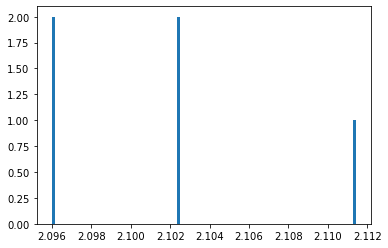

In [242]:
plt.hist(finite["error"]["5"], bins=100)
plt.show()

## Smooth Digital Option Payoffs

In [7]:
phi = np.random.standard_normal(1)

In [28]:
y = 1.0 / (1 + np.exp(-0 / 0.1))
y

0.5